In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b12e358fe52b854f528928608252a655dd6f4c3c1f8475f2cf8d0dba157f3d00
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_list, col, explode, lit, udf
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.types import ArrayType, FloatType

spark = SparkSession.builder.appName("Optimize Service Offerings with Reverse Mapping").getOrCreate()

data = spark.read.format("csv").option("header", "true").load("/content/drive/MyDrive/services.csv")

fpa_data = data.groupBy("Customer ID").agg(collect_list("Internet Type").alias("items"))

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.5, minConfidence=0.6)
fpm_model = fpGrowth.fit(fpa_data)
frequent_itemsets = fpm_model.freqItemsets

exploded_data = fpa_data.select("Customer ID", "items").withColumn("item", explode(col("items")))

user_indexer = StringIndexer(inputCol="Customer ID", outputCol="user_id").fit(data)
item_indexer = StringIndexer(inputCol="item", outputCol="item_id").fit(exploded_data)

data = user_indexer.transform(data)
exploded_data = exploded_data.join(data.select("Customer ID", "user_id"), "Customer ID")
exploded_data = item_indexer.transform(exploded_data)



#ALS MODEL
als_data = exploded_data.select("user_id", "item_id").distinct().withColumn("rating", lit(1))
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="item_id", ratingCol="rating", implicitPrefs=True)
als_model = als.fit(als_data)
recommendations = als_model.recommendForAllUsers(10)
recommendations = recommendations.withColumn("recommendation", explode("recommendations")).select("user_id", "recommendation.*")

user_id_to_customer_id = IndexToString(inputCol="user_id", outputCol="Customer ID", labels=user_indexer.labels)
item_id_to_item = IndexToString(inputCol="item_id", outputCol="Internet Type", labels=item_indexer.labels)
recommendations = user_id_to_customer_id.transform(recommendations)
recommendations = item_id_to_item.transform(recommendations)

recommendations.select("Customer ID", "Internet Type", "rating").show(truncate=False)


spark.stop()

+-----------+-------------+-------------+
|Customer ID|Internet Type|rating       |
+-----------+-------------+-------------+
|0002-ORFBO |Cable        |0.92184204   |
|0002-ORFBO |None         |-0.0035593119|
|0002-ORFBO |Fiber Optic  |-0.0038248887|
|0002-ORFBO |DSL          |-0.010070672 |
|0003-MKNFE |Cable        |0.92184204   |
|0003-MKNFE |None         |-0.0035593119|
|0003-MKNFE |Fiber Optic  |-0.0038248887|
|0003-MKNFE |DSL          |-0.010070672 |
|0004-TLHLJ |Fiber Optic  |0.9229968    |
|0004-TLHLJ |DSL          |0.0038748689 |
|0004-TLHLJ |None         |9.2761114E-4 |
|0004-TLHLJ |Cable        |-0.003820799 |
|0011-IGKFF |Fiber Optic  |0.9229968    |
|0011-IGKFF |DSL          |0.0038748689 |
|0011-IGKFF |None         |9.2761114E-4 |
|0011-IGKFF |Cable        |-0.003820799 |
|0013-EXCHZ |Fiber Optic  |0.9229968    |
|0013-EXCHZ |DSL          |0.0038748689 |
|0013-EXCHZ |None         |9.2761114E-4 |
|0013-EXCHZ |Cable        |-0.003820799 |
+-----------+-------------+-------

<ipython-input-3-5da5cb419256>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=internet_type_counts, x='Internet Type', y='Number of Customers', palette='viridis')


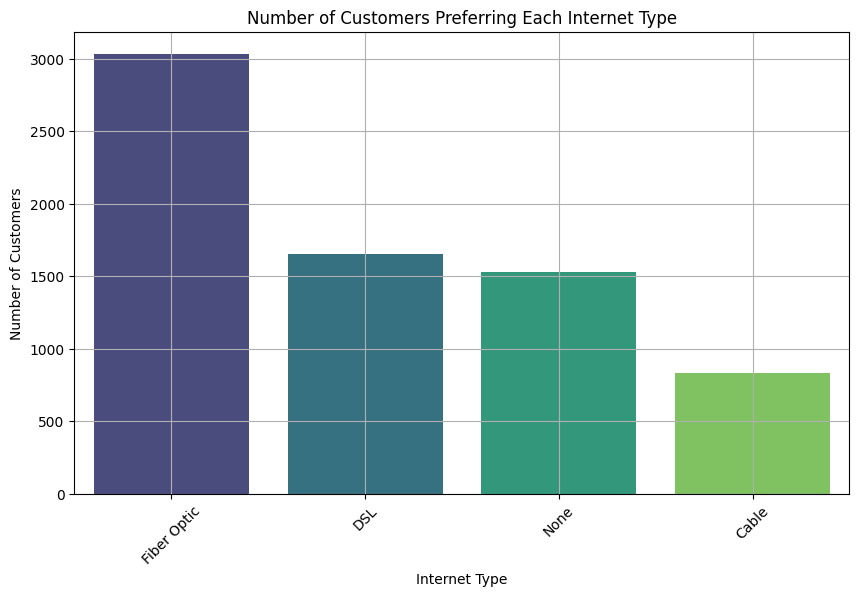

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_list, col, explode, lit, udf
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.types import ArrayType, FloatType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder.appName("Optimize Service Offerings with Reverse Mapping").getOrCreate()
data = spark.read.format("csv").option("header", "true").load("/content/drive/MyDrive/services.csv")


fpa_data = data.groupBy("Customer ID").agg(collect_list("Internet Type").alias("items"))
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.5, minConfidence=0.6)
fpm_model = fpGrowth.fit(fpa_data)
frequent_itemsets = fpm_model.freqItemsets


exploded_data = fpa_data.select("Customer ID", "items").withColumn("item", explode(col("items")))


user_indexer = StringIndexer(inputCol="Customer ID", outputCol="user_id").fit(data)
item_indexer = StringIndexer(inputCol="item", outputCol="item_id").fit(exploded_data)

data = user_indexer.transform(data)
exploded_data = exploded_data.join(data.select("Customer ID", "user_id"), "Customer ID")  # Join to get user_id in exploded_data
exploded_data = item_indexer.transform(exploded_data)

#ALS MODEL
als_data = exploded_data.select("user_id", "item_id").distinct().withColumn("rating", lit(1))
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="item_id", ratingCol="rating", implicitPrefs=True)
als_model = als.fit(als_data)

recommendations = als_model.recommendForAllUsers(10)
recommendations = recommendations.withColumn("recommendation", explode("recommendations")).select("user_id", "recommendation.*")


user_id_to_customer_id = IndexToString(inputCol="user_id", outputCol="Customer ID", labels=user_indexer.labels)
item_id_to_item = IndexToString(inputCol="item_id", outputCol="Internet Type", labels=item_indexer.labels)
recommendations = user_id_to_customer_id.transform(recommendations)
recommendations = item_id_to_item.transform(recommendations)


final_df = recommendations.select("Customer ID", "Internet Type", "rating")

pandas_df = final_df.toPandas()

pandas_df['rating'] = pandas_df['rating'].astype(float)
max_ratings = pandas_df.groupby(['Customer ID', 'Internet Type']).rating.max().reset_index()

idx = max_ratings.groupby(['Customer ID'])['rating'].transform(max) == max_ratings['rating']
max_ratings = max_ratings[idx]

max_ratings = max_ratings.drop_duplicates(subset=['Customer ID', 'rating'], keep='first')


#BAR CHART
internet_type_counts = max_ratings['Internet Type'].value_counts().reset_index()
internet_type_counts.columns = ['Internet Type', 'Number of Customers']


plt.figure(figsize=(10, 6))


sns.barplot(data=internet_type_counts, x='Internet Type', y='Number of Customers', palette='viridis')


plt.title('Number of Customers Preferring Each Internet Type')
plt.xlabel('Internet Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

plt.grid(True)
plt.show()



spark.stop()


<ipython-input-4-e4f700be5328>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Internet Type', y='Total Revenue', data=revenue_analysis_pd, ax=axes[0], palette='viridis')
<ipython-input-4-e4f700be5328>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Internet Type', y='Average Revenue', data=revenue_analysis_pd, ax=axes[1], palette='viridis')


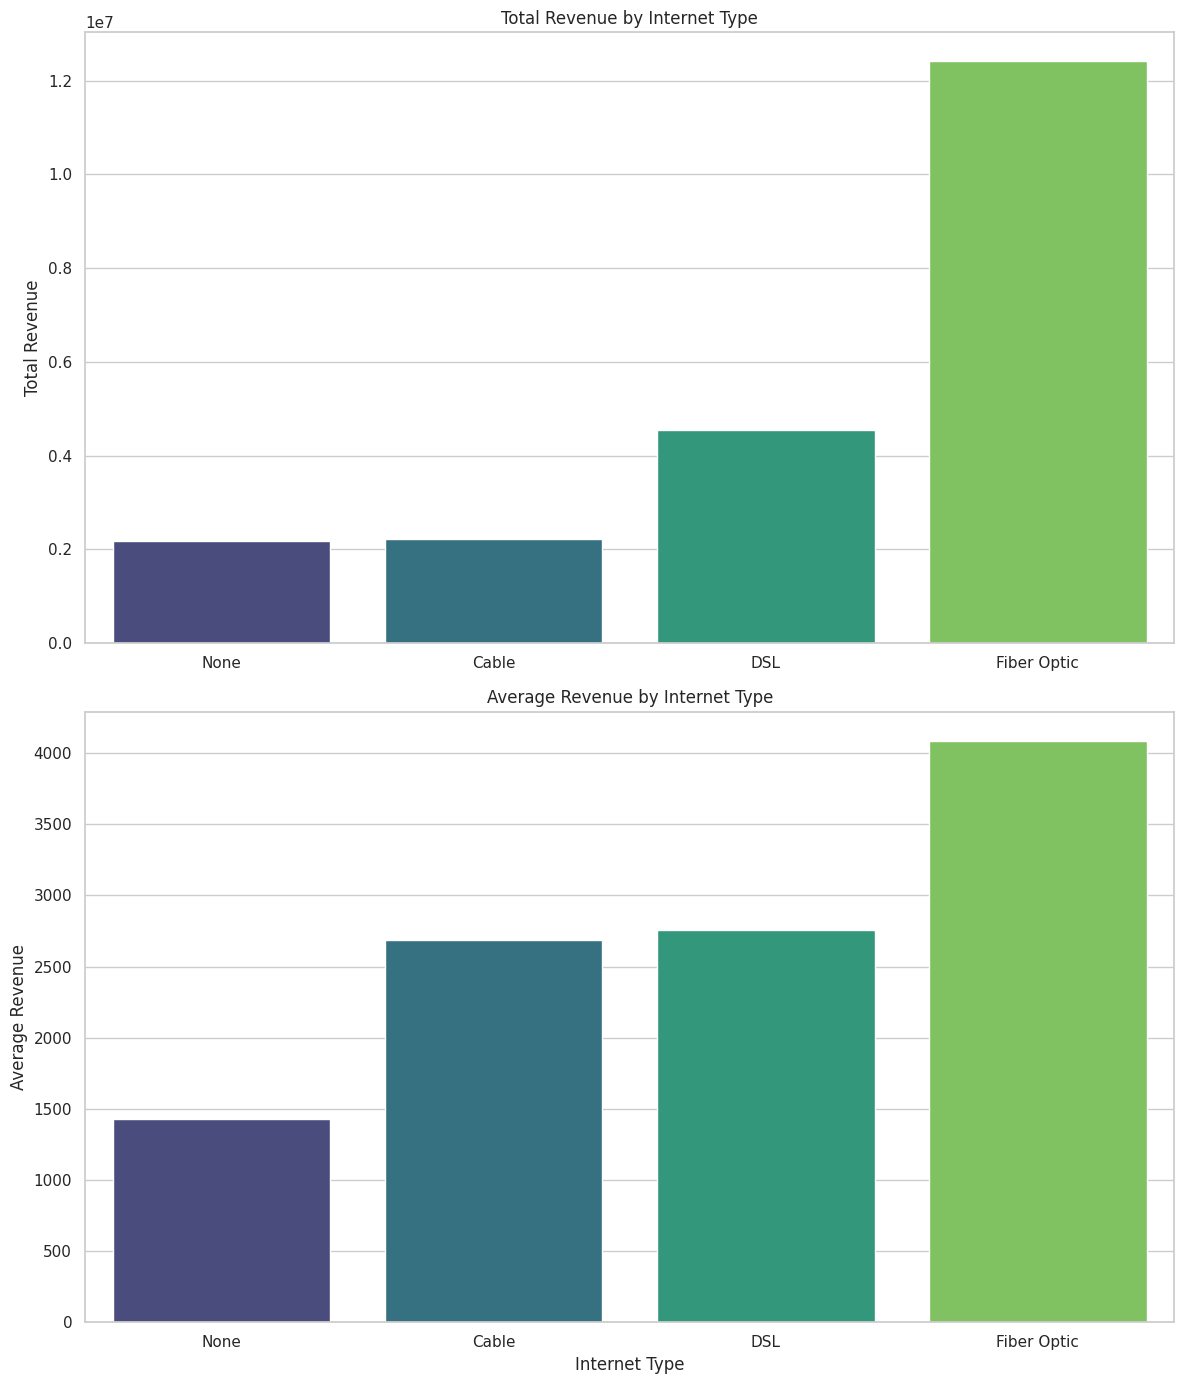

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


spark = SparkSession.builder.appName("Profit Analysis by Internet Type").getOrCreate()


data_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/drive/MyDrive/services.csv")


revenue_analysis = data_df.groupBy("Internet Type").agg(
    sum("Monthly Charge").alias("Total Monthly Charges"),
    avg("Monthly Charge").alias("Average Monthly Charge"),
    sum("Total Charges").alias("Total Charges"),
    avg("Total Charges").alias("Average Total Charges"),
    sum("Total Extra Data Charges").alias("Total Extra Data Charges"),
    avg("Total Extra Data Charges").alias("Average Extra Data Charges"),
    sum("Total Long Distance Charges").alias("Total Long Distance Charges"),
    avg("Total Long Distance Charges").alias("Average Long Distance Charges"),
    sum("Total Revenue").alias("Total Revenue"),
    avg("Total Revenue").alias("Average Revenue")
)

revenue_analysis_pd = revenue_analysis.toPandas()

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.barplot(x='Internet Type', y='Total Revenue', data=revenue_analysis_pd, ax=axes[0], palette='viridis')
axes[0].set_title('Total Revenue by Internet Type')
axes[0].set_ylabel('Total Revenue')
axes[0].set_xlabel('')

sns.barplot(x='Internet Type', y='Average Revenue', data=revenue_analysis_pd, ax=axes[1], palette='viridis')
axes[1].set_title('Average Revenue by Internet Type')
axes[1].set_ylabel('Average Revenue')
axes[1].set_xlabel('Internet Type')

plt.tight_layout()
plt.show()

spark.stop()
